In [19]:
import binascii

In [15]:
datei = open('resources/WN_LATEST/WN2402231135_000', 'rb')

In [22]:
with open('resources/WN_LATEST/WN2402231135_000', 'rb') as datei:
    content = datei.read()
    binary_string = ' '.join(map(lambda x: '{:08b}'.format(x), content[:100]))

    # Remove spaces from the binary string
    binary_string = binary_string.replace(" ", "")

    # Split the binary string into 8-bit chunks
    chunks = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]

    # Convert each chunk to its corresponding ASCII character
    ascii_string = ''.join(chr(int(chunk, 2)) for chunk in chunks)

    print("ASCII string:", ascii_string)

ASCII string: WN231135100000224BY   2640094VS 5SW  P40003HPR E-01INT   5GP1200x1100VV 000MF 00000008MS  2<>Ä)Ä)Ä)


In [31]:
# hexadecimal in decimal umwandeln
hex_string_little_endian = "7A03"

# flip hex string
flipped = hex_string_little_endian[2:4] + hex_string_little_endian[0:2]

# flipped to decimal
decimal = int(flipped, 16)
# decimal = 0

# print(decimal)

rvp6 = decimal * .1
dbz = (rvp6/2)-32.5

print(dbz)

R = ((10**(dbz/10))/200)**(5/8)

print(R)

12.0
0.20504833762477986


# get the data from the internet

In [128]:
import requests
import tarfile
import io
import os

def getData():
    # get the WN_LATEST.tar.bz2 file from the adress https://opendata.dwd.de/weather/radar/composite/wn/
    url = "https://opendata.dwd.de/weather/radar/composite/wn/WN_LATEST.tar.bz2"
    output_dir = "resources/WN_LATEST"
    response = requests.get(url)

    if response.status_code == 200:
        # Open the tar.bz2 archive using a file-like object from the response content
        with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:bz2") as tar:
            # Create the output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            # Extract files ending with "_000" to the output directory
            for member in tar.getmembers():
                # if member.name.endswith(f"_{number}"):
                tar.extract(member, path=output_dir)
            print("Files extracted successfully.")
        
    else:
        print("Failed to download the file.")

# Get the header information and get the body

In [130]:
# split header and body using the ETX character (00000011)

def getHeaderAndBody(index):
    # Define the directory containing the files
    directory = "resources/WN_LATEST"

    # List all files in the directory
    files = os.listdir(directory)

    # Filter the files to get the one ending with "_000"
    target_file = [file for file in files if file.endswith(f"_{index}")]

    # Check if the file exists
    if target_file:
        target_file = os.path.join(directory, target_file[0])
        # Open and read the contents of the file
        with open(target_file, "rb") as file:
            content = file.read()
    else:
        print(f"No file ending with '_{index}' found.")

    # with open('resources/WN_LATEST_old/WN2402231135_000', 'rb') as datei:
    #     content = datei.read()
    binary_string = ''.join(map(lambda x: '{:08b}'.format(x), content))

    # Split the binary data into 8-bit frames
    frames = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]

    # Search for ETX within each frame
    etx_frame_index = None
    for i, frame in enumerate(frames):
        if frame == "00000011":
            etx_frame_index = i
            break

    # If ETX found within a frame, split the binary data at the ETX position
    if etx_frame_index is not None:
        header = ''.join(frames[:etx_frame_index])
        body = ''.join(frames[etx_frame_index + 1:])
    else:
        print("ETX not found within a single frame.")

    # Display the results
    if etx_frame_index is not None:
        # convert binary to ascii
        header_ascii = ''.join(chr(int(header[i:i+8], 2)) for i in range(0, len(header), 8))
        print("ASCII data before ETX:", header_ascii)
        print("length of the body (16 bit windows): ", len(body)/16)

    return header_ascii, body

In [132]:
def getHeaderInformation(header_ascii):

    # get the informtion of the body and save it in a dict
    meta_data = {}

    # split header_ascii at spaces
    header_ascii_split = header_ascii.split(" ")
    header_ascii_split_filtered = list(filter(lambda x: x != "", header_ascii_split))

    # get the time of measurement
    # first six characters after "WN" and the four numbers before "BY" at index 0 of the header
    time_of_measurement = header_ascii_split_filtered[0][-4:-2] + header_ascii_split_filtered[0][-6:-4] + header_ascii_split_filtered[0][2:8]
    # the time is now in the format "YYMMDDHHMMSS"
    meta_data["time_of_measurement"] = time_of_measurement

    # get the accuracy of the data
    accuracy = header_ascii_split_filtered[4][0:4]
    meta_data["accuracy"] = accuracy

    # factor (by computing the value of the accuracy string. The string looks like "E-01")
    factor = 10 ** (-int(accuracy[2:4]))
    meta_data["factor"] = factor

    # getting the interval in minutes of the data
    interval = header_ascii_split_filtered[5].split("GP")[0]
    meta_data["interval"] = interval

    # get the forecast time in minutes since the measurement
    forecastTime = header_ascii_split_filtered[6].split("MF")[0]
    meta_data["forecastTime"] = forecastTime

    print(meta_data)

    return meta_data

# convert the body binary string into dBZ values

In [138]:
def getR(body, factor):

    # split the body into 16 bit windows
    windows = [body[i:i+16] for i in range(0, len(body), 16)]
    # flip the windows
    windows = [window[8:16] + window[0:8] for window in windows]

    # print the first 100 windows
    # print(windows[:100])

    # convert the 16 bit windows to decimal
    windows_decimal = [int(window, 2) for window in windows]
    # replace each window with a value greater than 4095 with None
    windows_decimal = [window if window < 4096 else None for window in windows_decimal]

    # convert the windows to dBZ if the value is not None
    dbz = [(decimal * factor) - 32.5 if decimal is not None else None for decimal in windows_decimal]

    # print(dbz[100500:100600])

    # convert the dBZ to R (mm/h) if the value is not None
    R = [(10**(decimal/10)/200)**(5/8) if decimal is not None else None for decimal in dbz]

    # print(R[100500:100600])

    print("got all R values")

    return R

# plot the data

In [144]:
# plot the R data in a grid of 1100x1200
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors

def plot(R, number):
    # Replace None values with 0
    R_filled = [-1 if value is None else value for value in R]
    # cap all value at 500
    R_filled = [value if value < 500 else 500 for value in R_filled]

    print(len(R_filled))

    # reshape the R data to a 1100x1200 grid
    R_reshaped = np.array(R_filled).reshape(1200, 1100)
    # flip the matrix vertically
    R_reshaped = np.flipud(R_reshaped)

    masked_R = np.ma.masked_equal(R_reshaped, -1)

    # print(R_reshaped[100:110, 0:10])

    print(np.max(R_reshaped))

    # plot the R data (remember that None values are not plotted) (make own color map with 0 as white and from 1 to 50 as viridis color map)
    log_viridis = matplotlib.colors.LogNorm(vmin=.3, vmax=masked_R.max())
    own_cmap_log = plt.cm.gnuplot2
    # own_cmap_log = plt.cm.gnuplot2
    own_cmap_log.set_bad(color='black')

    # save plot to image
    plt.imshow(masked_R, cmap=own_cmap_log, norm=log_viridis)
    # plt.colorbar()
    plt.savefig(f'resources/WN_plots/{number}.png')

    print("plot saved")


# run everything

In [134]:
getData()

Files extracted successfully.


ASCII data before ETX: WN232145100000224BY   2640094VS 5SW  P40003HPR E-01INT   5GP1200x1100VV 000MF 00000008MS  2<>
length of the body (16 bit windows):  1320000.0
{'time_of_measurement': '2402232145', 'accuracy': 'E-01', 'factor': 0.1, 'interval': '5', 'forecastTime': '000'}
got all R values
1320000
500.0
plot saved
-----------------
ASCII data before ETX: WN232145100000224BY   2640094VS 5SW  P40003HPR E-01INT   5GP1200x1100VV 005MF 00000008MS  2<>
length of the body (16 bit windows):  1320000.0
{'time_of_measurement': '2402232145', 'accuracy': 'E-01', 'factor': 0.1, 'interval': '5', 'forecastTime': '005'}
got all R values
1320000
500.0
plot saved
-----------------
ASCII data before ETX: WN232145100000224BY   2640094VS 5SW  P40003HPR E-01INT   5GP1200x1100VV 010MF 00000008MS  2<>
length of the body (16 bit windows):  1320000.0
{'time_of_measurement': '2402232145', 'accuracy': 'E-01', 'factor': 0.1, 'interval': '5', 'forecastTime': '010'}
got all R values
1320000
500.0
plot saved
----

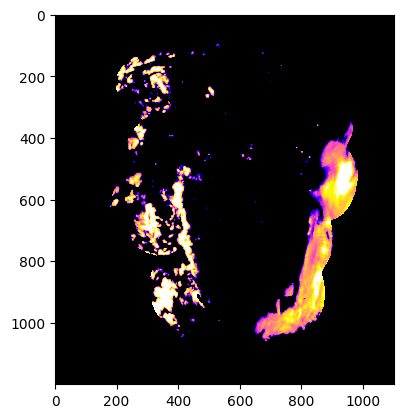

In [145]:
forecast_numbers = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075", "080", "085", "090", "095", "100", "105", "110", "115", "120"]

# make dir resources/WN_plots/ if it does not exist
os.makedirs("resources/WN_plots", exist_ok=True)
# delete all files in the directory
files = os.listdir("resources/WN_plots")
for file in files:
    os.remove(os.path.join("resources/WN_plots", file))

for number in forecast_numbers:
    header_ascii, body = getHeaderAndBody(number)
    meta_data = getHeaderInformation(header_ascii)
    R = getR(body, meta_data["factor"])
    plot(R, number)
    print("-----------------")


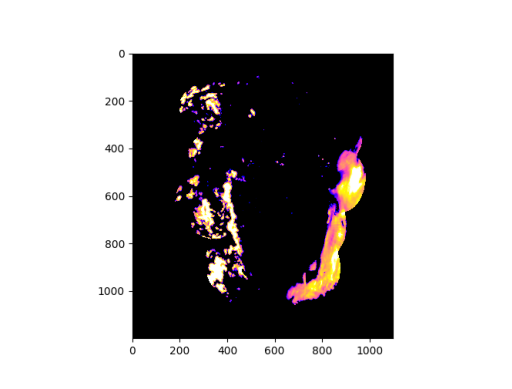

In [147]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the directory containing the images
directory = "resources/WN_plots"

# List all image files in the directory
files = sorted([file for file in os.listdir(directory) if file.endswith(".png")])

# Create a figure and axis
fig, ax = plt.subplots()

# Load the first image
first_image = plt.imread(os.path.join(directory, files[0]))

# Initialize the image plot with the first image
img = ax.imshow(first_image)

# Function to update the image in the animation
def update(i):
    image_file = os.path.join(directory, files[i])
    img.set_data(plt.imread(image_file))
    return img,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(files), interval=200)

ax.axis('off')

# Set up writer for saving the animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as a video file
ani.save('animation.mp4', writer=writer)

# Display the animation
plt.show()